<a href="https://colab.research.google.com/github/HyeongChanHam/Lung_Cancer_detection/blob/master/U_net_report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import random
import sys
import tensorflow as tf
import matplotlib.pyplot as plt
from skimage.io import imread, imshow
from tqdm import tqdm
from skimage.transform import resize


from keras.callbacks import TensorBoard

from keras.models import Model, load_model
from keras.optimizers import Adam
from keras.optimizers import SGD
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
tf.test.gpu_device_name()

from google.colab import drive
drive.mount('/content/gdrive')

PATH = "gdrive/My Drive/lung_cancer/"
dataset = 'small'
if dataset == 'small':
    img_path = PATH+'small_data/image_small/'
    mask_path = PATH+'small_data/mask_small/'
else:
    img_path = PATH+'big_data/images/image/'
    mask_path = PATH+'big_data/masks/mask/'

Using TensorFlow backend.


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# #sample 100 patients from whole dataset
# import shutil
# path_from = "gdrive/My Drive/lung_cancer/big_data/"
# path_to = "gdrive/My Drive/lung_cancer/small_data/"
# # shutil.copy
# for i in range(1,743):
#     shutil.copy(path_from + 'images/image/'+img_ids[i], path_to +'image_small/'+ img_ids[i])
#     shutil.copy(path_from + 'masks/mask/' + label_ids[i], path_to +'mask_small/'+ label_ids[i])

In [0]:
img_ids = next(os.walk(img_path))[2]
mask_ids = next(os.walk(mask_path))[2]
img_ids.sort()
mask_ids.sort()
print(img_ids)
print(mask_ids)

print("number of images : ",len(img_ids))
print("number of masks : ",len(mask_ids))

assert len(img_ids) == len(mask_ids), "images and mask have different samples"

IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 1

In [4]:
# load all data to memory
X_train = np.zeros((len(img_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(img_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.bool)

sys.stdout.flush()
for n, id_ in tqdm(enumerate(img_ids), total=len(img_ids)):
    path = img_path +id_
    img = np.expand_dims(imread(path),axis=2)
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img

for n, id_ in tqdm(enumerate(mask_ids), total=len(mask_ids)):
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH), dtype=np.bool)
    path = mask_path+id_
    label = np.expand_dims(imread(path), axis=2)
    mask = resize(label, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    Y_train[n] = mask

100%|██████████| 741/741 [09:17<00:00,  1.33it/s]


In [0]:
# shuffle images
def train_test_split(shuffle=False, norm = False, split_ratio = 0.8):
    ind_list = [i for i in range(len(X_train))]

    if shuffle:
        random.shuffle(ind_list)

    if norm == 'z':
        # z-score normalization
        X_train_norm = (X_train - X_train.mean()) / X_train.std()
    elif norm == 'mm_norm':
        # min-max normalization
        X_train_norm = (X_train - X_train.min()) / (X_train.max() - X_train.min())
    else:
        X_train_norm = X_train

    X_train_norm = X_train_norm[ind_list]
    Y_train_norm = Y_train[ind_list]

    _X_train = X_train_norm[:int(X_train.shape[0]*split_ratio)]
    _Y_train = Y_train_norm[:int(Y_train.shape[0]*split_ratio)]

    _X_val = X_train_norm[int(X_train.shape[0]*split_ratio):]
    _Y_val = Y_train_norm[int(Y_train.shape[0]*split_ratio):]

    return _X_train, _Y_train, _X_val, _Y_val


# Define IoU metric
def IoU(y_true, y_pred):
    y_pred = tf.cast(tf.greater(y_pred, 0.5),tf.float32)
    intersection = tf.reduce_sum(y_true*y_pred)
    union =tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return intersection / union

earlystopper = EarlyStopping(patience=10, verbose=0)
checkpointer = ModelCheckpoint('model-dsbowl2020-4.h5', verbose=0, save_best_only=True)

def build_model(opt, act):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = Lambda(lambda x: x) (inputs)

    activ = act
    c1 = Conv2D(16, (3, 3), activation=activ, kernel_initializer='he_normal', padding='same') (s)
    c1 = Dropout(0.1) (c1)
    c1 = Conv2D(16, (3, 3), activation=activ, kernel_initializer='he_normal', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = Conv2D(32, (3, 3), activation=activ, kernel_initializer='he_normal', padding='same') (p1)
    c2 = Dropout(0.1) (c2)
    c2 = Conv2D(32, (3, 3), activation=activ, kernel_initializer='he_normal', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(64, (3, 3), activation=activ, kernel_initializer='he_normal', padding='same') (p2)
    c3 = Dropout(0.2) (c3)
    c3 = Conv2D(64, (3, 3), activation=activ, kernel_initializer='he_normal', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(128, (3, 3), activation=activ, kernel_initializer='he_normal', padding='same') (p3)
    c4 = Dropout(0.2) (c4)
    c4 = Conv2D(128, (3, 3), activation=activ, kernel_initializer='he_normal', padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(256, (3, 3), activation=activ, kernel_initializer='he_normal', padding='same') (p4)
    c5 = Dropout(0.3) (c5)
    c5 = Conv2D(256, (3, 3), activation=activ, kernel_initializer='he_normal', padding='same') (c5)

    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation=activ, kernel_initializer='he_normal', padding='same') (u6)
    c6 = Dropout(0.2) (c6)
    c6 = Conv2D(128, (3, 3), activation=activ, kernel_initializer='he_normal', padding='same') (c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation=activ, kernel_initializer='he_normal', padding='same') (u7)
    c7 = Dropout(0.2) (c7)
    c7 = Conv2D(64, (3, 3), activation=activ, kernel_initializer='he_normal', padding='same') (c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation=activ, kernel_initializer='he_normal', padding='same') (u8)
    c8 = Dropout(0.1) (c8)
    c8 = Conv2D(32, (3, 3), activation=activ, kernel_initializer='he_normal', padding='same') (c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation=activ, kernel_initializer='he_normal', padding='same') (u9)
    c9 = Dropout(0.1) (c9)
    c9 = Conv2D(16, (3, 3), activation=activ, kernel_initializer='he_normal', padding='same') (c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer=opt, loss=tf.keras.losses.binary_crossentropy,metrics=[IoU])

    return model

def model_train(model,_X_train, _Y_train ):
    with tf.device('/device:GPU:0'):
        results = model.fit(_X_train, _Y_train, validation_split=0.1, batch_size=4, epochs=100, 
                        callbacks=[earlystopper, checkpointer], verbose=1)
    return results, model

def draw_fig(results, shuffle, norm, act, opt, loss, avail):
    title = "shuffle : {}, normalization : {}, activation : {}, optimizer : {}, loss function : {}, available prediction : {:.0%}".format(
        shuffle, norm, act, opt, loss, avail)
    fig, ax = plt.subplots(1,2, figsize=(10,3))
    loss = results.history['loss']
    val_loss = results.history['val_loss']
    ax[0].plot(loss, 'r', label='loss')
    ax[0].plot(val_loss,'b',label='val_loss')
    ax[0].legend()
    _IoU = results.history['IoU']
    _val_IoU = results.history['val_IoU']
    ax[1].plot(_IoU, 'g',label='IoU')
    ax[1].plot(_val_IoU, 'c',label='val_IoU')
    ax[1].legend()
    plt.suptitle(title)
    plt.show()

# Predict on train, val and test
def count_valid_pred(model,_X_val, _Y_val):
    model = load_model('model-dsbowl2020-4.h5',{'IoU':IoU})
    preds_val = model.predict(_X_val, verbose=0)

    preds_val_t = (preds_val > 0.5).astype(np.uint8)

    IoU_vec = np.array([])
    '''
    print out images
    '''
    for i in range(10):
        ix = random.randint(0, len(_X_val))
        fig, ax = plt.subplots(1,3,figsize=(10,6))
        ax[0].imshow(_X_val[ix][:,:,0],cmap='gray')
        ax[0].axis('off')
        ax[1].imshow(np.squeeze(preds_val_t[ix][:,:,0]),cmap='gray')
        ax[1].title.set_text("prediction")
        ax[1].axis('off')
        ax[2].imshow(np.squeeze(_Y_val[ix][:,:,0]),cmap='gray')
        ax[2].title.set_text("ground truth")
        ax[2].axis('off')
        plt.show()
        print("IoU : ",IoU(tf.convert_to_tensor(preds_val_t[ix],tf.float32),tf.convert_to_tensor(_Y_val[ix],tf.float32)).numpy())

    for i in range(len(preds_val_t)):
        IoU_vec = np.append(IoU_vec, IoU(tf.convert_to_tensor(preds_val_t[i],tf.float32),tf.convert_to_tensor(_Y_val[i],tf.float32)).numpy())
    return np.where(IoU_vec>0,1,0).mean()

def iter(shuffle, norm,  opt,act, loss):
    _X_train, _Y_train, _X_val, _Y_val = train_test_split(shuffle, norm, split_ratio = 0.8)
    model = build_model(opt, act)
    results, model = model_train(model,_X_train, _Y_train)
    draw_fig(results, shuffle, norm, act, opt, loss, count_valid_pred(model,_X_val, _Y_val))
    return results

In [0]:
iter_dict = {'shuffle':[True], 'norm':[False,'z',  'mm_norm'],
             'opt':['adam'], 'act':['relu', 'elu']}
opt_dict = {}
opt_dict['adam'] = Adam(lr = 0.0001, beta_1=0.9, beta_2=0.999)
opt_dict['SGD'] = SGD(learning_rate = 0.0001, momentum=0.999)

trial 1, True_False_adam_relu


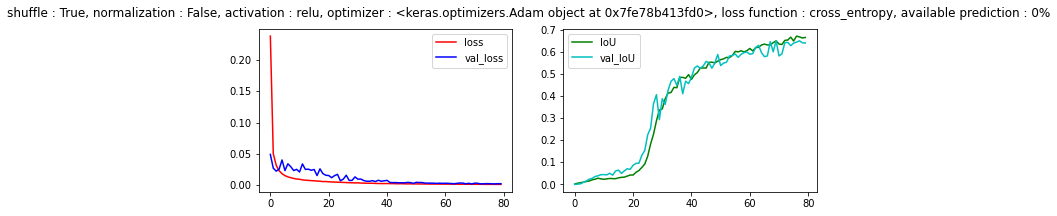

val_IoU : 0.6393110156059265
trial 2, True_False_adam_relu


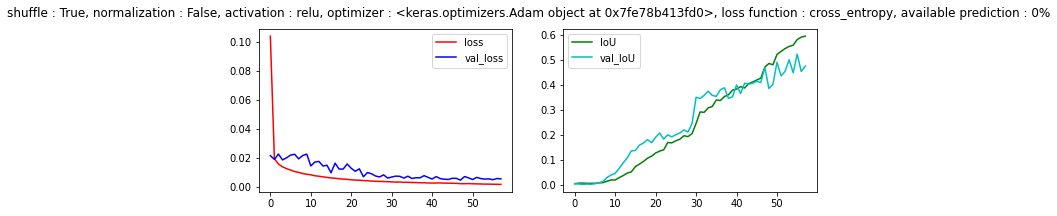

val_IoU : 0.4752730131149292
trial 3, True_False_adam_relu


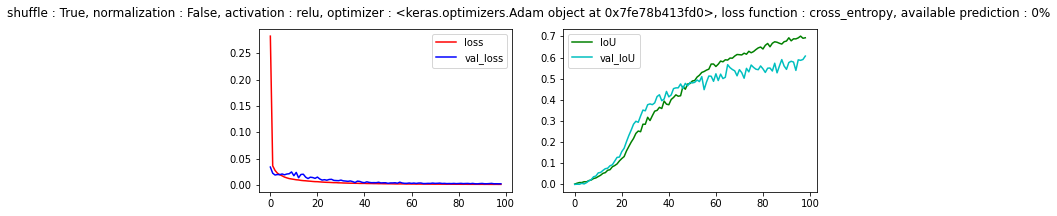

val_IoU : 0.6069406867027283
trial 1, True_False_adam_elu


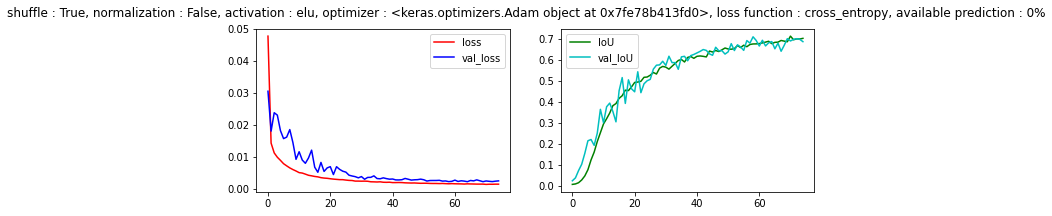

val_IoU : 0.6892120242118835
trial 2, True_False_adam_elu


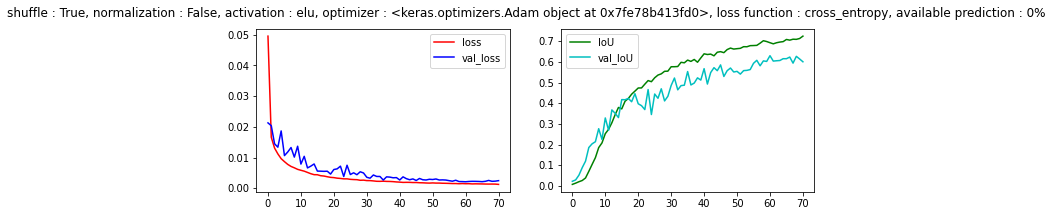

val_IoU : 0.6007857918739319
trial 3, True_False_adam_elu


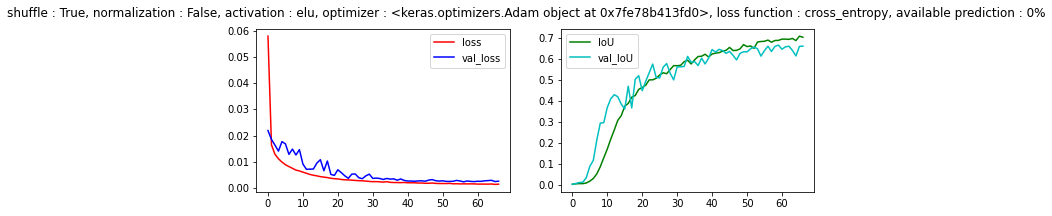

val_IoU : 0.6594416499137878
trial 1, True_z_adam_relu


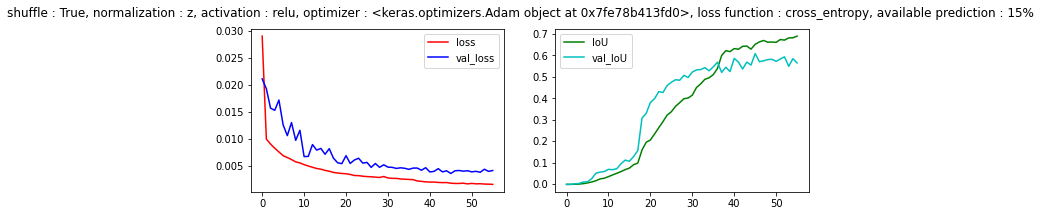

val_IoU : 0.5651372671127319
trial 2, True_z_adam_relu


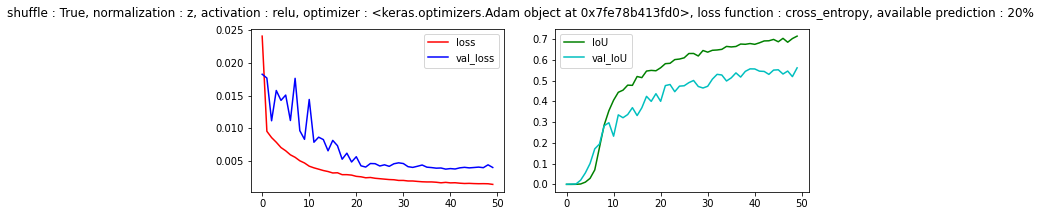

val_IoU : 0.5612394213676453
trial 3, True_z_adam_relu


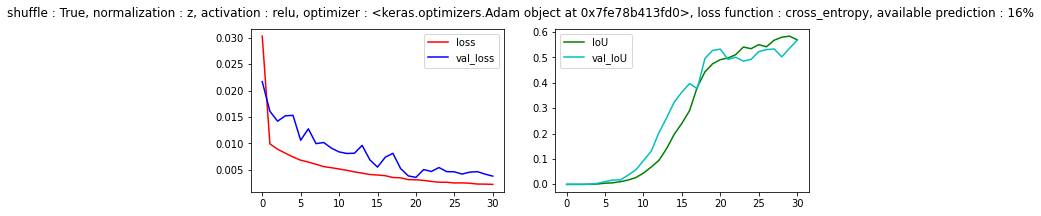

val_IoU : 0.5674213767051697
trial 1, True_z_adam_elu


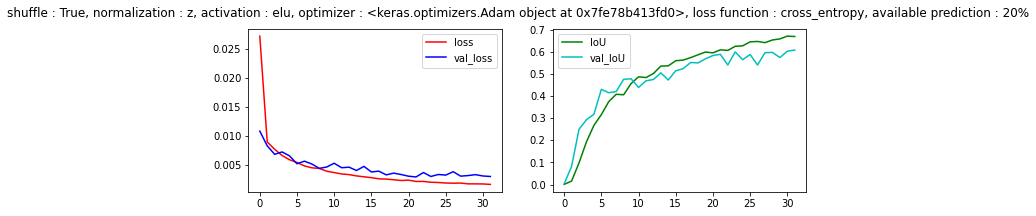

val_IoU : 0.6088288426399231
trial 2, True_z_adam_elu


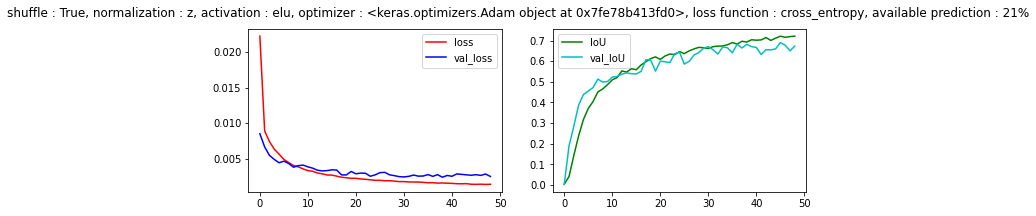

val_IoU : 0.6732431054115295
trial 3, True_z_adam_elu


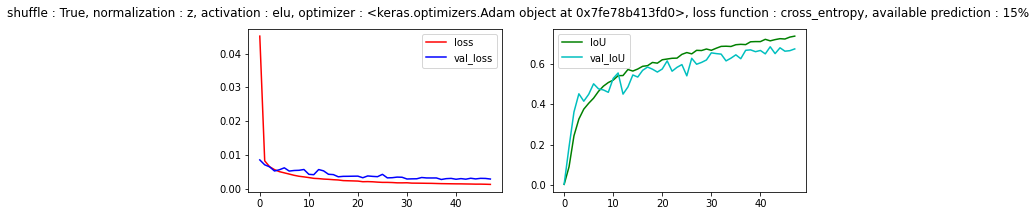

val_IoU : 0.673401951789856
trial 1, True_mm_norm_adam_relu


KeyboardInterrupt: ignored

In [63]:
result2 = {}
for shuffle in iter_dict['shuffle']:
    for norm in iter_dict['norm']:
        for opt in iter_dict['opt']:
            for act in iter_dict['act']:
                for _ in range(3):
                    print("trial {}, {}_{}_{}_{}".format(_+1, shuffle,norm,opt,act))
                    result2["{}_{}_{}_{}".format(shuffle,norm,opt,act)] = iter(shuffle, norm, opt_dict[opt], act, "cross_entropy")
                    print("val_IoU : {}".format(result2["{}_{}_{}_{}".format(shuffle,norm,opt,act)].history['val_IoU'][-1]))


Train on 532 samples, validate on 60 samples
Epoch 1/100
532/532 [==============================] - 8s 15ms/step - loss: 0.0363 - IoU: 1.6399e-04 - val_loss: 0.0130 - val_IoU: 0.0000e+00
Epoch 2/100
532/532 [==============================] - 6s 12ms/step - loss: 0.0106 - IoU: 6.1128e-05 - val_loss: 0.0164 - val_IoU: 0.0083
Epoch 3/100
532/532 [==============================] - 6s 12ms/step - loss: 0.0100 - IoU: 6.3719e-05 - val_loss: 0.0125 - val_IoU: 0.0048
Epoch 4/100
532/532 [==============================] - 6s 12ms/step - loss: 0.0095 - IoU: 0.0018 - val_loss: 0.0152 - val_IoU: 0.0265
Epoch 5/100
532/532 [==============================] - 6s 12ms/step - loss: 0.0091 - IoU: 0.0026 - val_loss: 0.0091 - val_IoU: 0.0106
Epoch 6/100
532/532 [==============================] - 6s 12ms/step - loss: 0.0086 - IoU: 0.0209 - val_loss: 0.0088 - val_IoU: 0.0399
Epoch 7/100
532/532 [==============================] - 6s 12ms/step - loss: 0.0079 - IoU: 0.0614 - val_loss: 0.0080 - val_IoU: 0.0274
E

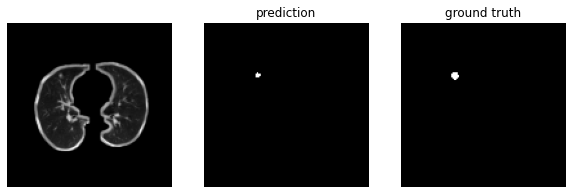

IoU :  0.44444445


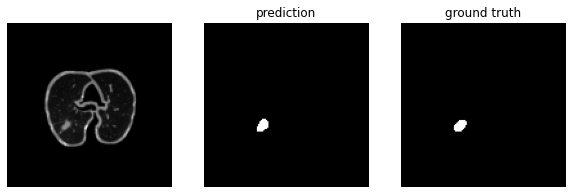

IoU :  0.82191783


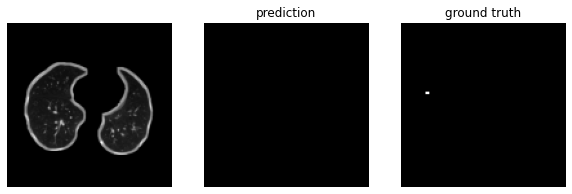

IoU :  0.0


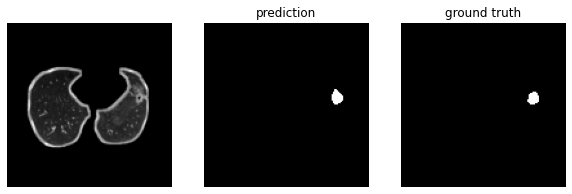

IoU :  0.79012346


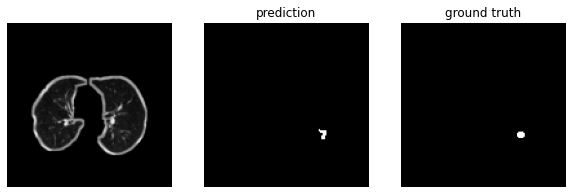

IoU :  0.43243244


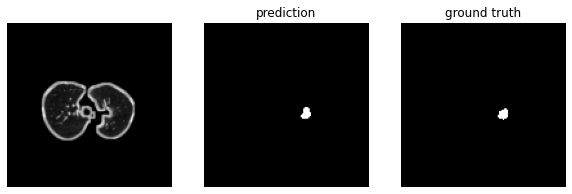

IoU :  0.7586207


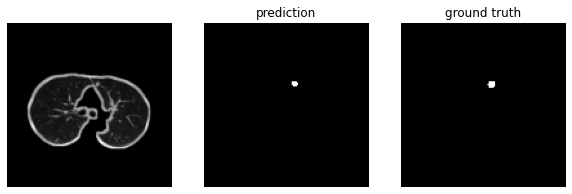

IoU :  0.68


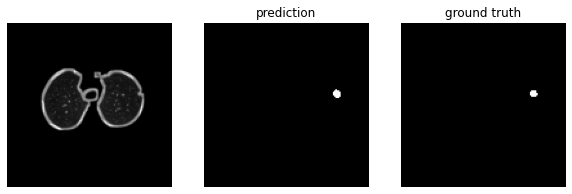

IoU :  0.8064516


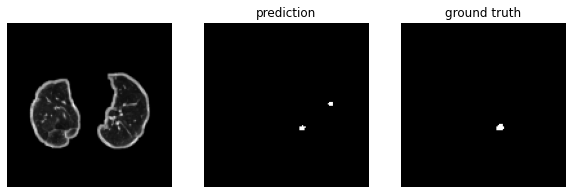

IoU :  0.4117647


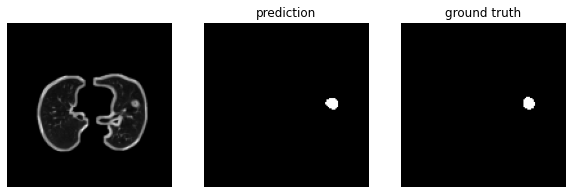

IoU :  0.84


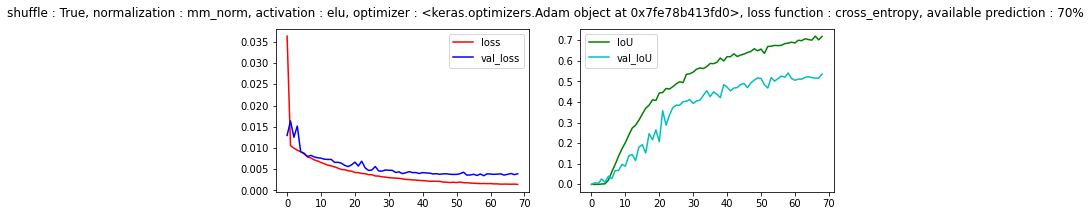

In [66]:
iter(True,'mm_norm' , opt_dict['adam'], 'elu', "cross_entropy")

Download history variables

In [0]:
save_result = result

In [0]:
from google.colab import files

In [0]:
files.download(save_result)

In [0]:
import pickle
save_result['False_False_SGD_elu'].history

In [0]:
files.download('history_False_False_SGD_elu1.json')

In [0]:
!rm False_False_adam_relu_2.json

In [0]:
for i in save_result.keys():
    print(i)

In [0]:
for key in save_result.keys():
    for i in range(2):
        with open('{}_{}.json'.format(key,i+1), 'wb') as f:
            pickle.dump(save_result[key].history,f)
        files.download('{}_{}.json'.format(key,i+1))

In [0]:
a = files.upload()

In [0]:
with open('history_False_False_SGD_elu1 (1).json', 'rb') as f:
    data = pickle.load(f)